In [1]:
# add folders to working path

In [2]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FastTensorlineComputation folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FastTensorlineComputation3D")

CPU times: user 132 µs, sys: 105 µs, total: 237 µs
Wall time: 144 µs


# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. The notebook is structured as follows:

1. Define analytic velocity field of the three-dimensional solution of the Euler equations, the steady and spatially periodic Arnold-Beltrami-Childress (ABC) flow:
\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} \sqrt{3}\sin(z)+\cos(y) \\ \sqrt{2}\sin(x) + \sqrt{3}\cos(z) \\ \sin(y)+\sqrt{2}\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3
\label{eq: periodicABC}
\end{equation}
<br />
2. Define computational parameters.
 <br />
3. Define spatio-temporal domain.
 <br />

# Analytic velocity field

Here we define the spatially periodic and steady three dimensional ABC-velocity field.

In [3]:
def velocity(x, y, z):

    u = sqrt(3)*np.sin(z)+np.cos(y)
    v = sqrt(2)*np.sin(x)+sqrt(3)*np.cos(z)
    w = np.sin(y)+sqrt(2)*np.cos(x)
    
    return np.array([u, v, w])

def dudx(x, y, z):
    return 0*x.copy()
def dudy(x, y, z):
    return -np.sin(y)
def dudz(x, y, z):
    return sqrt(3)*np.cos(z)

def dvdx(x, y, z):
    return sqrt(2)*np.cos(x)
def dvdy(x, y, z):
    return 0*x.copy()
def dvdz(x, y, z):
    return -sqrt(3)*np.sin(z)

def dwdx(x, y, z):
    return -sqrt(2)*np.sin(x)
def dwdy(x, y, z):
    return np.cos(y)
def dwdz(x, y, z):
    return 0*x.copy()

def vorticity(x, y, z):
    
    #vorticity_x = dwdy(x, y, z)-dudz(x, y, z)
    #vorticity_y = dudz(x, y, z)-dwdx(x, y, z)
    #vorticity_z = dvdx(x, y, z)-dudy(x, y, z)
    
    return velocity(x, y, z)

def dduddx(x, y, z):
    return 0*x.copy()
def ddudxdy(x, y, z):
    return 0*x.copy()
def ddudxdz(x, y, z):
    return 0*x.copy()

def ddudydx(x, y, z):
    return 0*x.copy()
def dduddy(x, y, z):
    return -np.cos(y)
def ddudydz(x, y, z):
    return 0*x.copy()

def ddudzdx(x, y, z):
    return 0*x.copy()
def ddudzdy(x, y, z):
    return 0*x.copy()
def dduddz(x, y, z):
    return -sqrt(3)*np.sin(z)

def ddvdydx(x, y, z):
    return 0*x.copy()
def ddvddy(x, y, z):
    return 0*x.copy()
def ddvdydz(x, y, z):
    return 0*x.copy()

def ddvddx(x, y, z):
    return -sqrt(2)*np.sin(x)
def ddvdxdy(x, y, z):
    return 0*x.copy()
def ddvdxdz(x, y, z):
    return 0*x.copy()

def ddvdxdz(x, y, z):
    return 0*x.copy()
def ddvdydz(x, y, z):
    return 0*x.copy()
def ddvddz(x, y, z):
    return -sqrt(3)*np.cos(z)

def dwdx(x, y, z):
    return -sqrt(2)*np.sin(x)
def dwdy(x, y, z):
    return np.cos(y)
def dwdz(x, y, z):
    return 0*x.copy()

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [4]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

# number of cores to be used for parallel computing
Ncores = 15

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [5]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 0 # float

# Time step-size (in days)
dt = 0.01 # float

# NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 14.1 µs


# Classic tensorline integration

In [ ]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen

from tqdm.notebook import tqdm

def oriented_vector(x_interp, idx_eigenvector):

    x = x_interp[:,0]
    y = x_interp[:,1]
    z = x_interp[:,2]
    
    grad_vel = np.zeros((x.shape[0], 3, 3))
    
    grad_vel[:,0,0] = dudx(x,y,z)
    grad_vel[:,1,0] = dvdx(x,y,z)
    grad_vel[:,2,0] = dwdx(x,y,z)
    
    grad_vel[:,0,1] = dudy(x,y,z)
    grad_vel[:,1,1] = dvdy(x,y,z)
    grad_vel[:,2,1] = dwdy(x,y,z)
    
    grad_vel[:,0,2] = dudz(x,y,z)
    grad_vel[:,1,2] = dvdz(x,y,z)
    grad_vel[:,2,2] = dwdz(x,y,z)
    
    # Compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(0, 2, 1))
    
    eigenvector = np.zeros((S.shape[0], 3))*np.nan
    
    for i in range(S.shape[0]):
            
        eigenvector[i,:] = eigen(S[i,:,:])[1][:,idx_eigenvector]
        
    return eigenvector
            
def RK4_classic_tensorline(x, x_prime_before, ds, idx_eigenvector):
    
    # Define starting point.
    x1 = x
    
    x1_interp = x1%(2*pi)
    
    # Compute x_prime at the beginning of the time-step
    x_prime = oriented_vector(x1_interp, idx_eigenvector)
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    k1 = ds * x_prime_reoriented

    #  position and time at the first midpoint.
    x2 = x1 + .5 * k1
    
    x2_interp = x2%(2*pi)
    
    # Compute x_prime at the first midpoint.
    x_prime = oriented_vector(x2_interp, idx_eigenvector)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k2 = ds * x_prime_reoriented

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    x3_interp = x3%(2*pi)
    
    # Compute x_prime at the second midpoint.
    x_prime = oriented_vector(x3_interp, idx_eigenvector)

    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k3 = ds * x_prime_reoriented
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    x4_interp = x4%(2*pi)
    
    # Compute x_prime at the endpoint.
    x_prime = oriented_vector(x4_interp, idx_eigenvector)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k4 = ds * x_prime_reoriented
    
    x_prime_avg = 1.0/6.0*(k1+2*k2+2*k3+k4)
    x_update = x+x_prime_avg
    
    return x_update, x_prime_avg

x_domain_poincare = np.linspace(xmin, xmax, 20, endpoint = True) # array (10, )
y_domain_poincare = np.linspace(ymin, ymax, 20, endpoint = True) # array (10, )
z_domain_poincare = np.linspace(zmin, zmax, 20, endpoint = True) # array (10, )

dx = x_domain_poincare[1]-x_domain_poincare[0]
dy = y_domain_poincare[1]-y_domain_poincare[0]
dz = z_domain_poincare[1]-z_domain_poincare[0]

X_domain_poincare, Y_domain_poincare, Z_domain_poincare = np.meshgrid(x_domain_poincare, y_domain_poincare, z_domain_poincare) # array (10, 10, 10) 

# Vectorize initial conditions by arranging them to a vector of size (10*10*10, 3)
x0 = X_domain_poincare[:,:,0].ravel()
y0 = Y_domain_poincare[:,:,0].ravel()
z0 = Z_domain_poincare[:,:,0].ravel()

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny*Nz)

ds = 0.1
s_range = np.arange(0, 2*10**4, ds)
idx_eigenvector = 1

def parallel_tensorlines(x0, y0, z0):
    
    X0 = np.zeros((x0.shape[0], 3))

    X0[:,0] = x0
    X0[:,1] = y0
    X0[:,2] = z0

    x_prime_before = np.zeros(X0.shape)
    x_prime_before[:,0] = 1
    
    X_tensorlines = np.zeros((len(s_range), X0.shape[0], X0.shape[1]))
    X_tensorlines[0,:,:] = X0.copy()
    
    for s in range(len(s_range)-1):
        if s % 2000 == 0:
            print("Percentage completed: ", int(100*s/len(s_range)))
        X_tensorlines[s+1,:,:], x_prime_before = RK4_classic_tensorline(X_tensorlines[s,:,:], x_prime_before, ds, idx_eigenvector)
        
    return X_tensorlines
    
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_tensorlines)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results from parallel computation
X_tensorlines = results[0]

for res in results[1:]:
    X_tensorlines = np.append(X_tensorlines, res, axis = 1)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


In [23]:
X_tensorlines_converged = X_tensorlines[-50:, :, :]%(2*pi)

X_prime_tensorlines = np.diff(X_tensorlines_converged, axis = 0)

xi_mid = X_prime_tensorlines[:,:,:].reshape(-1,3)

omega = vorticity(X_tensorlines_converged[:,:,0].ravel(), X_tensorlines_converged[:,:,1].ravel(), X_tensorlines_converged[:,:,2].ravel()).transpose()

omega = omega.reshape((X_tensorlines_converged.shape[0], X_tensorlines_converged.shape[1], -1))

angle = []
s_mid = []
s_max = []

for i in tqdm(range(X_tensorlines_converged.shape[0]-1)):
    for j in range(X_tensorlines_converged.shape[1]):
        omega = vorticity(X_tensorlines_converged[i,j,0], X_tensorlines_converged[i,j,1], X_tensorlines_converged[i,j,2])
        tangent_invariant_manifold = X_prime_tensorlines[i,j,:]
        angle.append(np.arccos(np.dot(omega, tangent_invariant_manifold)/np.sqrt((np.dot(omega, omega)*np.dot(tangent_invariant_manifold, tangent_invariant_manifold)))))        
        #s_mid.append(interp_s_mid(X_tensorlines_converged[i,j,:]))

  0%|          | 0/49 [00:00<?, ?it/s]

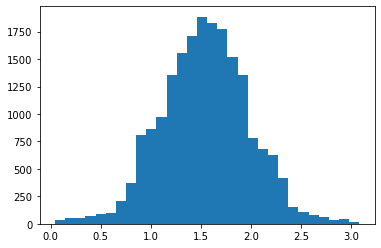

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
ax.hist(angle, bins = 30)
plt.show()

In [31]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

# import math tools
from math import pi

def parallel_PoincareMap(time, Fmap, t0, tN):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    # time-interval [10^4, 2*10^4] (long-term behaviour of trajectories)
    time_poincare = np.arange(t0, tN, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    
    # iterate along long-term trajectories 
    for i in range(len(z_interp)-1):
        
        if np.abs(z_interp[i]%(2*pi)-z_interp[i+1]%(2*pi)) > pi:
            
            z_interp_shifted = z_interp[i:i+2]-np.around((z_interp[i]/(2*pi)), 0)*2*pi
            
            root = -z_interp_shifted[0]*dt/(z_interp_shifted[1]-z_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
    
    return x_intersec, y_intersec, z_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(s_range, X_tensorlines[:,i,:], t0=0.8*s_range[-1], tN=s_range[-1]) for i in range(X_tensorlines.shape[1]))

x_intersec, y_intersec, z_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:    5.4s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:   12.9s
[Parallel(n_jobs=15)]: Done 400 out of 400 | elapsed:   15.1s finished


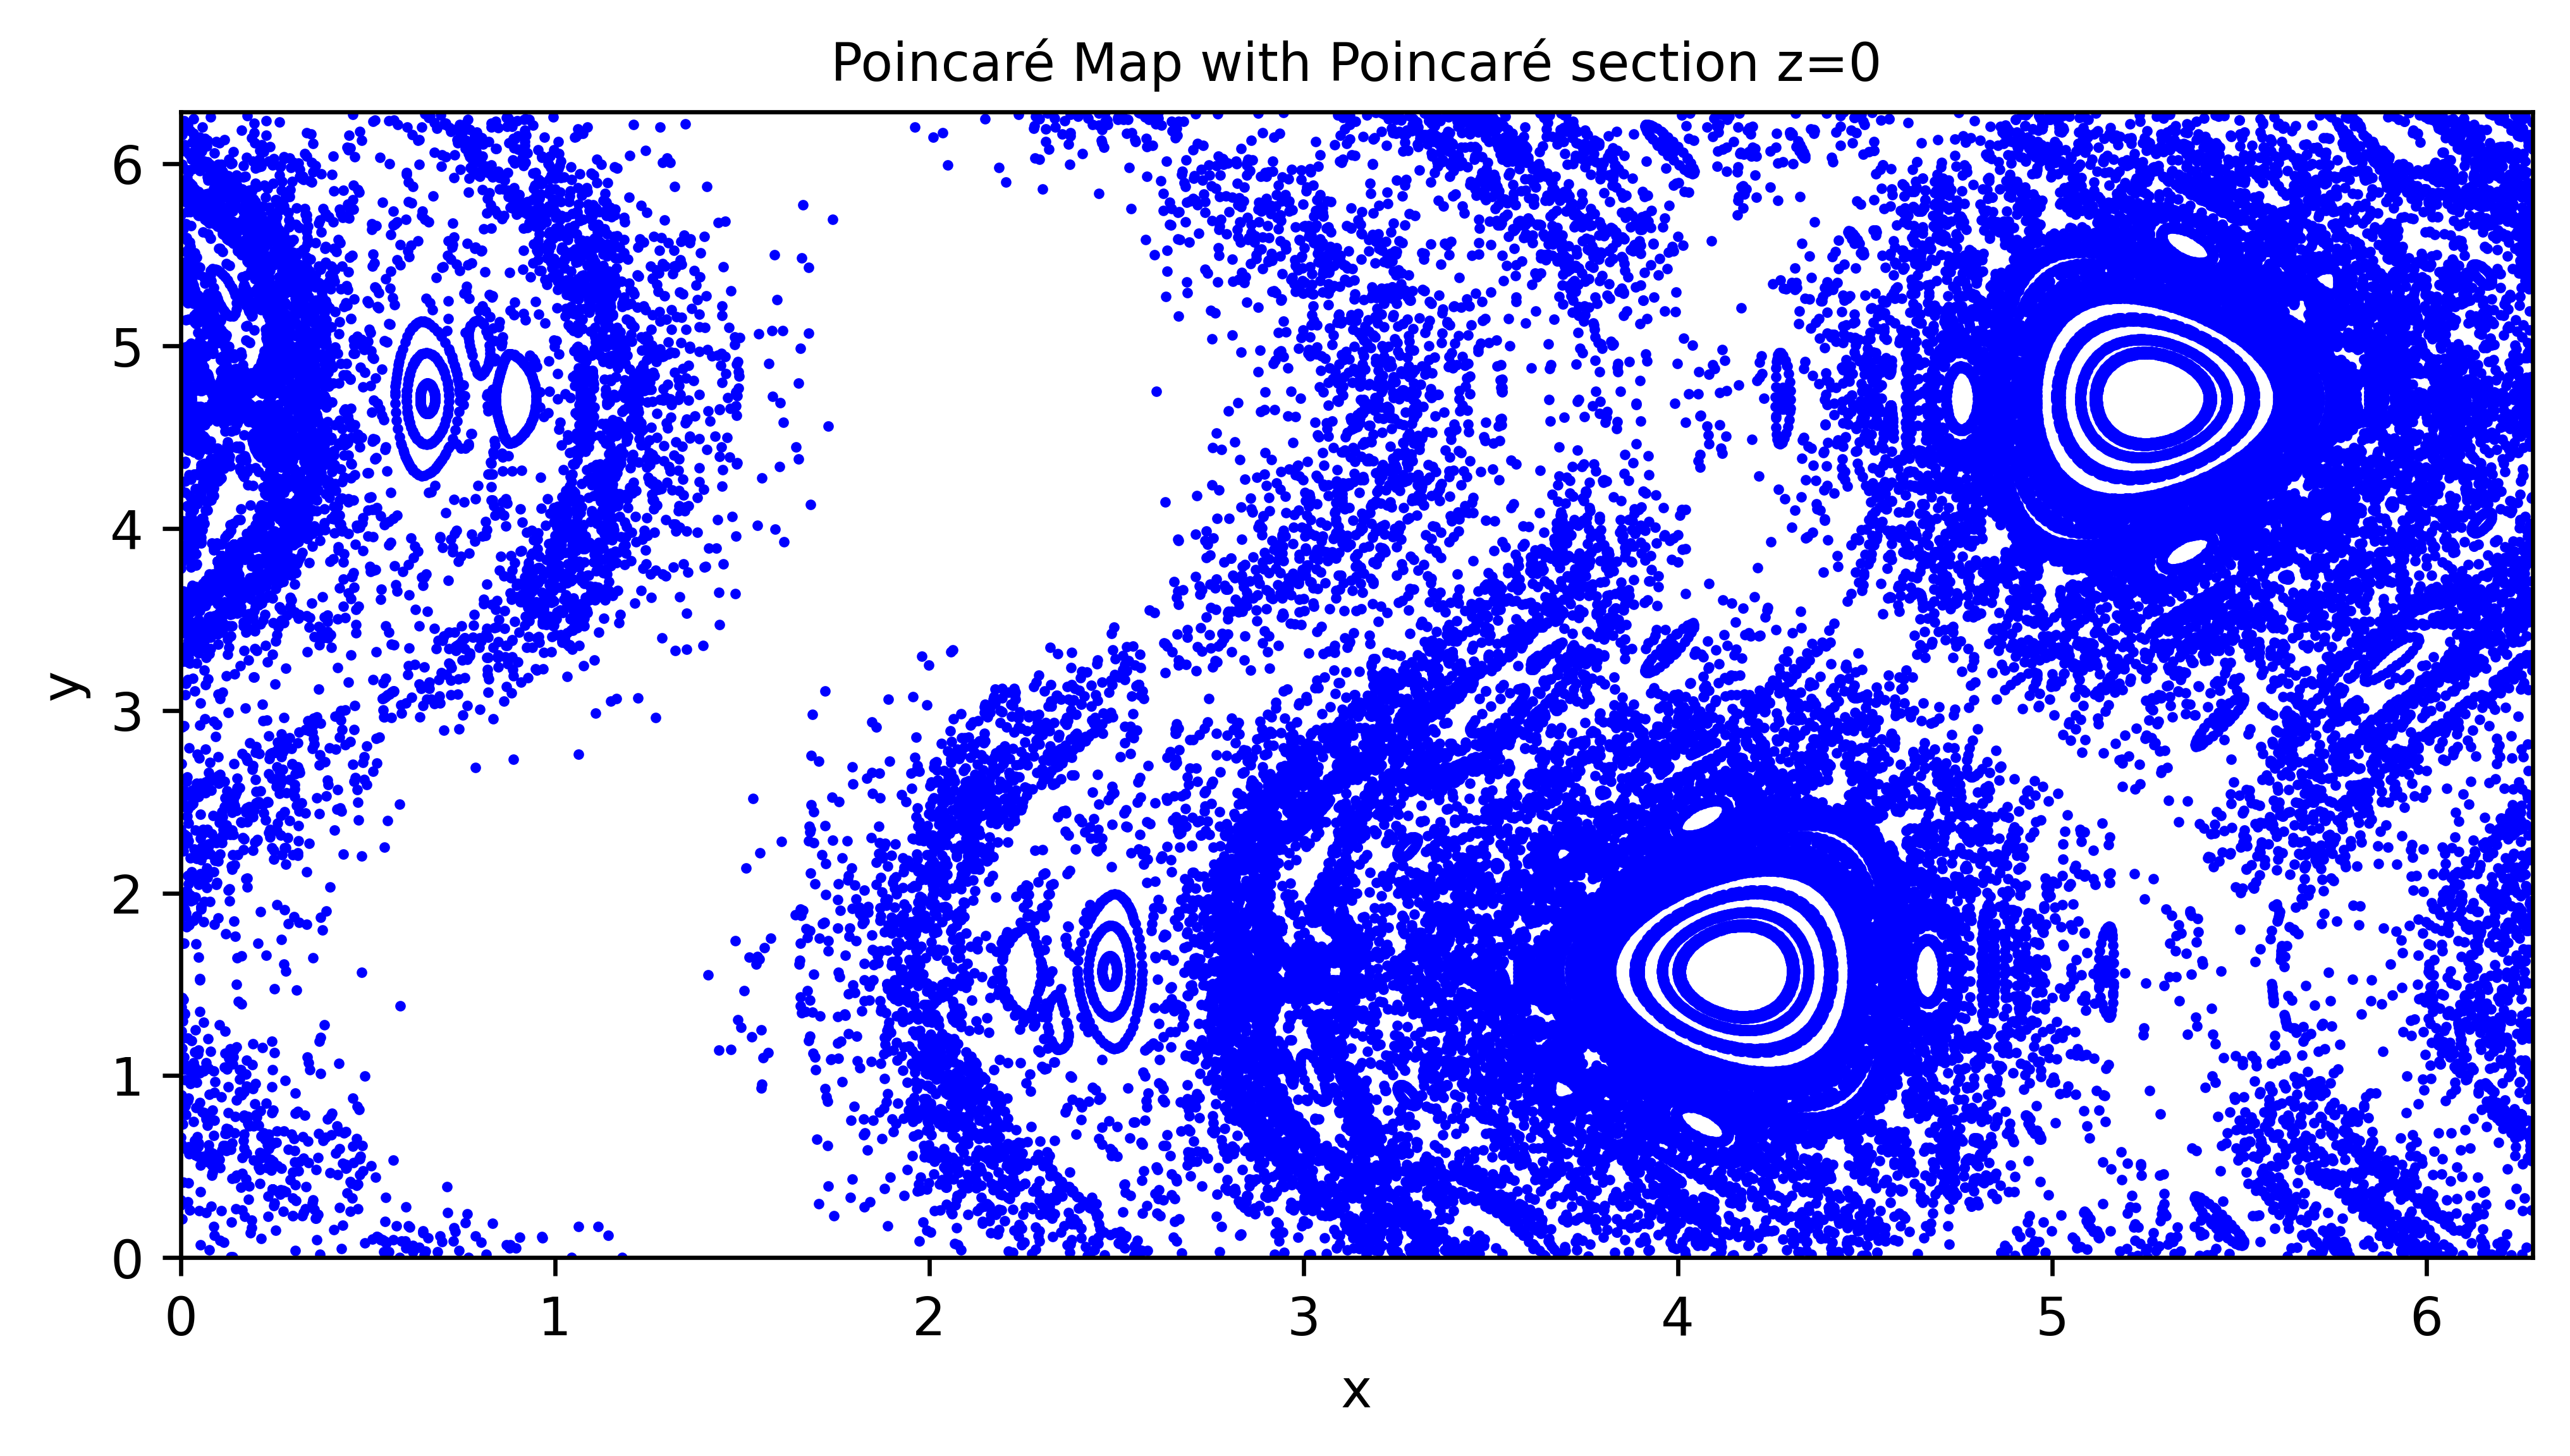

In [33]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = 1, marker = "o")

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

# Title
ax.set_title(r'Poincaré Map with Poincaré section z=0', fontsize = 10)

plt.show()